$\newcommand{\mb}[1]{\mathbf{ #1 }}$
$\newcommand{\bs}[1]{\boldsymbol{ #1 }}$
$\newcommand{\bb}[1]{\mathbb{ #1 }}$

$\newcommand{\R}{\bb{R}}$

$\newcommand{\ip}[2]{\left\langle #1, #2 \right\rangle}$
$\newcommand{\norm}[1]{\left\Vert #1 \right\Vert}$

$\newcommand{\der}[2]{\frac{\mathrm{d} #1 }{\mathrm{d} #2 }}$
$\newcommand{\derp}[2]{\frac{\partial #1 }{\partial #2 }}$

In [1]:
import numpy as np
import sys
sys.path.append('../../../')

# Define experiment parameters

In [2]:
from core.dynamics import RoboticDynamics

class FiniteDimKoopSys(RoboticDynamics):
    def __init__(self, lambd, mu, c):
        RoboticDynamics.__init__(self, 2, 2)
        self.params = lambd, mu, c
    
    def D(self, q):
        return np.array([[1, 0],[0, (q[0]+1)**(-1)]])
    
    def C(self, q, q_dot):
        labmd, mu, c = self.params
        return -np.array([[lambd, 0], [(q[0]+1)**(-1)*(2*lambd - mu)*c*q_dot[0], (q[0]+1)**(-1)*mu]])
    
    def G(self, q):
        return np.array([0, 0])
    
    def B(self, q):
        return np.array([[1, 0], [0, 1]])

n, m = 4, 2
lambd, mu, c = .3, .2, -.5
finite_dim_koop_sys = FiniteDimKoopSys(lambd, mu, c)

In [3]:
from core.dynamics import LinearSystemDynamics

A_lin = np.array([[0, 0, 1, 0],
                  [0, 0, 0, 1],
                  [0, 0, lambd, 0],
                  [0, 0, 0, mu]])
B_lin = np.array([[0, 0],
                  [0, 0],
                  [1, 0],
                  [0, 1]])
dt = 1e-2
linearized_sys = LinearSystemDynamics(A_lin, B_lin)

# MPC parameters:
umax = np.array([10., 10.])
umin = -umax
xmax = np.array([3., 6., 3., 3.])
xmin = -xmax
q, r = 1e5, 1
Q_mpc = q*np.eye(n)
R_mpc = r*np.eye(m)
traj_length = 200

# Design trajectory:
x0 = np.array([0., 0., 0., 0.])
set_pt = np.array([2., 5., 0., 0.])

# Define nonlinear MPC for trajectory generation

#### Define model

In [4]:
from casadi import *
import do_mpc

model = do_mpc.model.Model('continuous')
x = model.set_variable('_x', 'x', (2,1))
dx = model.set_variable('_x', 'dx', (2,1))
u = model.set_variable('_u', 'force', (2,1))
ddx = model.set_variable('_z', 'ddx', (2,1))

model.set_rhs('x', dx)
model.set_rhs('dx', ddx)

eul_lagrange = vertcat(
    ddx[0] - (lambd*dx[0] + u[0]),
    ddx[1] - (mu*dx[1] + (2*lambd-mu)*c*dx[0]**2 + (x[0]+1)*u[1])
)
model.set_alg('euler_lagrange', eul_lagrange)
quad_cost = q*((x[0]-set_pt[0])**2
              +(x[1]-set_pt[1])**2
              +(dx[0]-set_pt[2])**2
              +(dx[1]-set_pt[3])**2)
model.set_expression(expr_name='cost', expr=quad_cost)
model.setup()

#### Define controller

In [5]:
mpc = do_mpc.controller.MPC(model)
setup_mpc = {
    'n_horizon': traj_length,
    'n_robust': 0,
    'open_loop': 0,
    't_step': dt,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 2,
    'collocation_ni': 2,
    'store_full_solution': True,
    # Use MA27 linear solver in ipopt for faster calculations:
    'nlpsol_opts': {'ipopt.linear_solver': 'mumps'}
}
mpc.set_param(**setup_mpc)
mpc.set_objective(lterm=SX.zeros(1,1), mterm=model.aux['cost'])
mpc.set_rterm(force=np.array([r, r]))

#mpc.bounds['lower', '_x', 'x'] = xmin[:2]
#mpc.bounds['lower', '_x', 'dx'] = xmin[2:]
#mpc.bounds['upper', '_x', 'x'] = xmax[:2]
#mpc.bounds['upper', '_x', 'dx'] = xmax[2:]

#mpc.bounds['lower','_u','force'] = umin
#mpc.bounds['upper', '_u', 'force'] = umax

mpc.setup()

#### Set up simulation and evaluate open loop prediction

In [6]:
mpc.x0 = x0
mpc.set_initial_guess()
mpc.make_step(x0)

xr_cl = np.vstack((mpc.data.prediction(('_x','x')).squeeze(), mpc.data.prediction(('_x','dx')).squeeze()))
ur_cl = mpc.data.prediction(('_u','force')).squeeze()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    27204
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3202

Total number of variables............................:     8428
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

# Construct Koopman bilinear form of the system

As a result of the careful construction of this system, there exists a Koopman canonical transform, $\mb z = T(\mb x)$ that exactly transforms the control-affine dynamics into a bilinear system. Consider the transformation:

\begin{equation}
    T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} 
    \phi_1(\mb q, \mb{\dot{q}})\\
    \phi_2(\mb q, \mb{\dot{q}})\\
    \phi_3(\mb q, \mb{\dot{q}})\\
    \phi_4(\mb q, \mb{\dot{q}})\\
    \phi_5(\mb q, \mb{\dot{q}})\\
    \phi_6(\mb q, \mb{\dot{q}})\\
    \end{bmatrix}
    = \begin{bmatrix} 
    q_1 - \frac{1}{\lambda}\dot{q}_1\\
    q_2 - \frac{1}{\mu} \dot{q}_2 + \frac{(2 \lambda - \mu)c}{2\lambda \mu} \dot{q}_1^2\\
    \dot{q}_1\\
    \dot{q}_2 - c \dot{q}_1^2\\
    \dot{q}_1^2\\
    1
    \end{bmatrix},
\end{equation}

where $\phi_1, \phi_2, \phi_3, \phi_4, \phi_5, \phi_6$ are eigenfunctions of the Koopman operator associated with the drift 
vector field $\mb f_0$. The matrix with the eigenvalue associated with the i-th eigenfunction on the i-th diagonal 
element is $F=\text{diag}(0, 0, \lambda, \mu, 2 \lambda, 0)$. Then, to reformulate the dynamics we have: 

\begin{equation} 
L_{\mb f_1} T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} -\frac{1}{\lambda}\\ \frac{(2\lambda - \mu)c}{\lambda \mu}\dot{q}_1\\ 1 \\ -2c\dot{q}_1 \\ 2\dot{q_1} \\ 0 \end{bmatrix}, \qquad 
L_{\mb f_2} T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} 0\\ -\frac{1}{\mu}(q_1 + 1)\\0 \\ q_1 + 1 \\ 0 \\ 0 \end{bmatrix} 
\end{equation}

and the dynamics can be equivalently transformed to a bilinear form $\mb{\dot{z}} = F \mb z + G_1\mb z u_1 + G_2\mb z u_2$ with 

\begin{equation}
F = \begin{bmatrix} 
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & \lambda & 0 & 0 & 0\\
0 & 0 & 0 & \mu & 0 & 0\\
0 & 0 & 0 & 0 & 2 \lambda & 0\\
0 & 0 & 0 & 0 & 0 & 0\\  
\end{bmatrix}, \qquad 
G_1 = \begin{bmatrix} 
0 & 0 & 0 & 0 & 0 & -\frac{1}{\lambda}\\
0 & 0 & \frac{(2\lambda - \mu)c}{\lambda \mu} & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 1\\
0 & 0 & -2c & 0 & 0 & 0\\
0 & 0 & 2 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\  
\end{bmatrix}
, \qquad 
G_2 = \begin{bmatrix} 
0 & 0 &  0 & 0 & 0 & 0\\
-\frac{1}{\mu} & 0 &  -\frac{1}{\lambda \mu} & 0 & 0 & -\frac{1}{\mu}\\
0 & 0 & 0 & 0 & 0 & 0\\
1 & 0 & \frac{1}{\lambda} & 0 & 0 & 1\\
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\  
\end{bmatrix}
\end{equation}

In [7]:
from koopman_core.dynamics import BilinearLiftedDynamics

F = np.array([[0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, lambd, 0, 0],
              [0, 0, 0, 0, mu, 0],
              [0, 0, 0, 0, 0, 2*lambd]])
G_1 = np.array([[0, 0, 0, 0, 0, 0],
                [-1/lambd, 0, 0, 0, 0, 0],
                [0, 0, 0, (2*lambd - mu)*c/(lambd*mu), 0, 0],
                [1, 0, 0, 0, 0, 0], 
                [0, 0, 0, -2*c, 0, 0], 
                [0, 0, 0, 2, 0, 0]])
G_2 = np.array([[0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [-1/mu, -1/mu, 0, -1/(lambd*mu), 0, 0],
                [0, 0, 0, 0, 0, 0], 
                [1, 1, 0, 1/lambd, 0, 0], 
                [0, 0, 0, 0, 0, 0]])
G = [G_1, G_2]
phi_fun = lambda x: np.array([1,
                            x[0,0] - 1/lambd*x[0,2],
                            x[0,1] - 1/mu*x[0,3] + (2*lambd - mu)*c/(2*lambd*mu)*x[0,2]**2,
                            x[0,2],
                            x[0,3] - c*x[0,2]**2,
                            x[0,2]**2])
phi_fun_grad = lambda x: np.array([[0., 0., 0., 0.]
                                   [1., 0., -1/lambd, 0.],
                                   [0., 1., (2*lambd-mu)*c/(lambd*mu)*x[0,2], -1/mu],
                                   [0., 0., 1., 0.],
                                   [0., 0., -2*c*x[0,2], 1.],
                                   [0., 0., 2*x[0,2], 0.]])

C_q = np.array([[0, 1, 0, 1/lambd, 0, 0],
                [0, 0, 1, 0, 1/mu, c/mu - ((2*lambd - mu)*c)/(2*lambd*mu)]])
C_qdot = np.array([[0, 0, 0, 1, 0, 0],
                   [0, 0, 0, 0, 1, c]])
C = np.concatenate((C_q, C_qdot), axis=0)

n_koop = 6

xtest = np.array([10, 2, 3, 4])
print(xtest, C@phi_fun(xtest.reshape(1,-1)))

koop_bilinear_sys = BilinearLiftedDynamics(n_koop, m, F, G, C, phi_fun)

[10  2  3  4] [10.  2.  3.  4.]


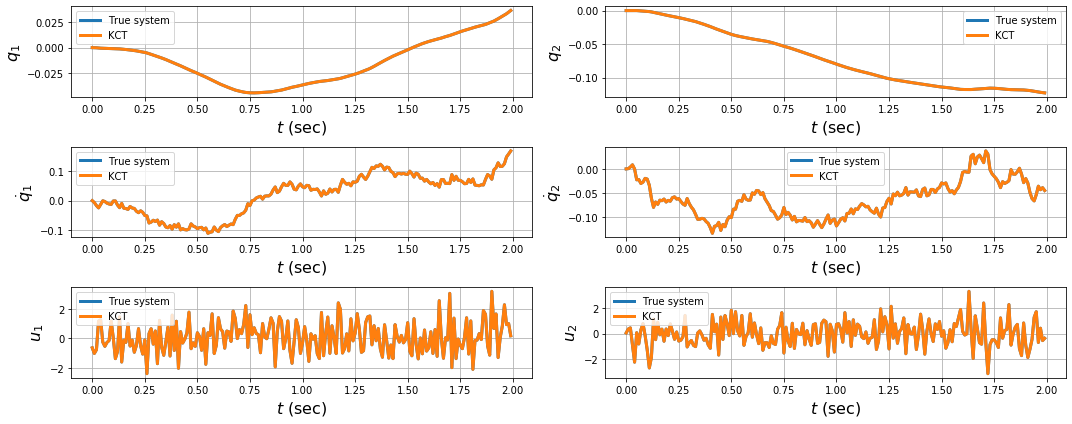

In [8]:
from matplotlib.pyplot import subplots, tight_layout, show
from koopman_core.controllers.openloop_controller import OpenLoopController

ol_controller = OpenLoopController(finite_dim_koop_sys, np.random.normal(size=(2,200)).T, np.arange(0,200)*dt)
z0 = phi_fun(x0.reshape((1,-1)))
xs, us = finite_dim_koop_sys.simulate(x0, ol_controller, np.arange(0,201)*dt)
zs_koop, us_koop = koop_bilinear_sys.simulate(z0, ol_controller, np.arange(0,201)*dt)
xs_koop = np.dot(C, zs_koop.T)

_, axs = subplots(3, 2, figsize=(15, 6))
ylabels = ['$q_1$', '$q_2$', '$\\dot{q}_1$', '$\\dot{q}_2$', '$u_1$', '$u_2$']

for ax, data_fb, data_koop, ylabel in zip(axs.flatten(), np.vstack((xs[:-1,:].T, us.T)), np.vstack((xs_koop[:,:-1], us_koop.T)), ylabels):
    ax.plot(np.arange(0,200)*dt, data_fb, linewidth=3, label='True system')
    ax.plot(np.arange(0,200)*dt, data_koop, linewidth=3, label='KCT')
    ax.set_ylabel(ylabel, fontsize=16)
    ax.grid()
    ax.set_xlabel('$t$ (sec)', fontsize=16)
    ax.legend()
    
    
tight_layout()
show()

# Design model predictive controllers based on the bilinear model

In [9]:
#from koopman_core.controllers import BilinearMPCController

#controller_koop = BilinearMPCController(koop_bilinear_sys, traj_length, dt, umin, umax, xmin, xmax, np.zeros_like(Q_mpc), R_mpc, Q_mpc, set_pt)

In [10]:
#controller_koop.eval(x0, 0.)
#xr_koop = koop_bilinear_sys.C@controller_koop.parse_result()
#ur_koop = controller_koop.get_control_prediction()

#### QP-MPC based on linear transformation of the bilinear dynamics

In [11]:
from koopman_core.controllers import BilinearMPCControllerCvx

controller_koop = BilinearMPCControllerCvx(koop_bilinear_sys, traj_length, dt, umin, umax, xmin, xmax, np.zeros_like(Q_mpc), R_mpc, Q_mpc, set_pt)
xr_koop, ur_koop = controller_koop.gen_trajectory(x0,0.)

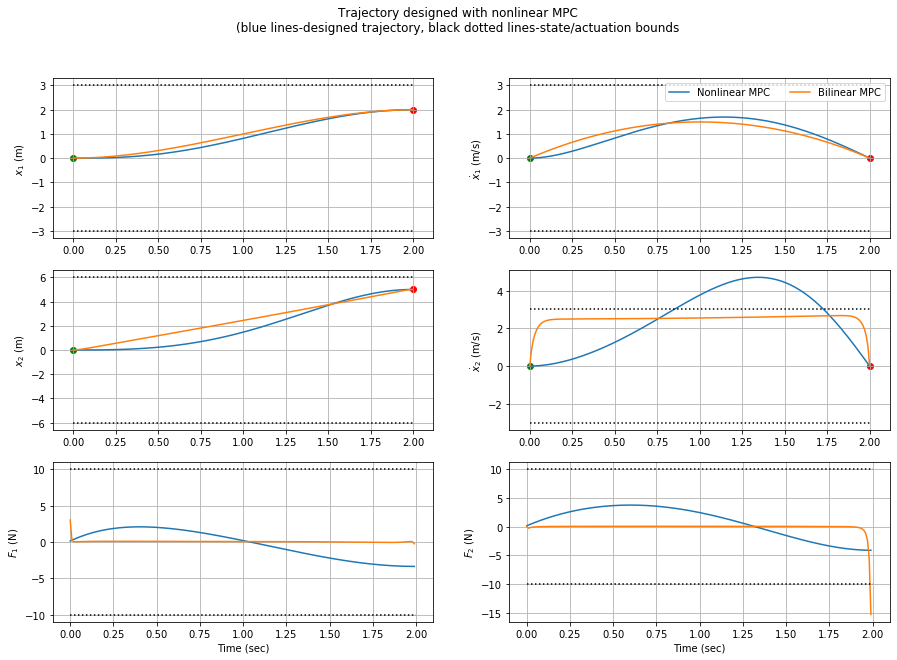

In [12]:
import matplotlib.pyplot as plt
t_eval = np.arange(0,traj_length+1)*dt
plot_inds = [0, 2, 1, 3, 0, 1]
labels = ['$x_1$ (m)', '$x_2$ (m)', '$\\dot{x}_1$ (m/s)','$\\dot{x}_2$ (m/s)','$F_1$ (N)','$F_2$ (N)']

plt.figure(figsize=(15,10))
plt.suptitle('Trajectory designed with nonlinear MPC\n(blue lines-designed trajectory, black dotted lines-state/actuation bounds')
for ii in range(6):
    ind = plot_inds[ii]
    if ii < 4:
        plt.subplot(3,2,ii+1)
        plt.plot(t_eval, xr_cl[ind,:], label='Nonlinear MPC')
        plt.plot(t_eval, xr_koop[ind,:], label='Bilinear MPC')
        plt.plot([0, 2.], [xmax[ind], xmax[ind]], ':k')
        plt.plot([0, 2.], [xmin[ind], xmin[ind]], ':k')
        plt.scatter(t_eval[0], x0[ind], color='g')
        plt.scatter(t_eval[-1], set_pt[ind], color='r')
        plt.ylabel(labels[ind])
        plt.grid()
        if ii==1:
            plt.legend(loc='upper right', ncol=3)
    else:
        plt.subplot(3,2,ii+1)
        plt.plot(t_eval[:-1],ur_cl[ind,:])
        plt.plot(t_eval[:-1],ur_koop[ind,:])
        plt.plot([0, 2.], [umax[ind], umax[ind]], ':k')
        plt.plot([0, 2.], [umin[ind], umin[ind]], ':k')
        plt.ylabel(labels[ii])
        plt.xlabel('Time (sec)')
        plt.grid()
            
plt.show()

In [14]:
traj_cost_ref = xr_cl[:,-1].T@Q_mpc@xr_cl[:,-1] + np.sum(np.diag(ur_cl.T@R_mpc@ur_cl))
traj_cost_koop = xr_koop[:,-1].T@Q_mpc@xr_koop[:,-1] + np.sum(np.diag(ur_koop.T@R_mpc@ur_koop))

print('Closed loop quadratic cost:')
print('   Ref:   ', "{:.3f}".format(traj_cost_ref),
      '\n   bEDMD: ', "{:.3f}".format(traj_cost_koop),
      )
print('\n   Relative increased cost Ref -> koop:  ', "{:.2f}".format(100*((traj_cost_koop)/(traj_cost_ref)-1)), ' %'
      )

Closed loop quadratic cost:
   Ref:    2902282.164 
   bEDMD:  2899046.254

   Relative increased cost Ref -> koop:   -0.11  %


#### Simulate system open loop with both control trajectories

In [15]:
from koopman_core.controllers import OpenLoopController
ol_controller = OpenLoopController(finite_dim_koop_sys, ur_cl.T, t_eval[:-1])
xs_cl, us_cl = finite_dim_koop_sys.simulate(x0, ol_controller, t_eval)
xs_cl, us_cl = xs_cl.T, us_cl.T

ol_controller_koop = OpenLoopController(finite_dim_koop_sys, ur_koop.T, t_eval[:-1])
xs_koop, us_koop = finite_dim_koop_sys.simulate(x0, ol_controller_koop, t_eval)
xs_koop, us_koop = xs_koop.T, us_koop.T

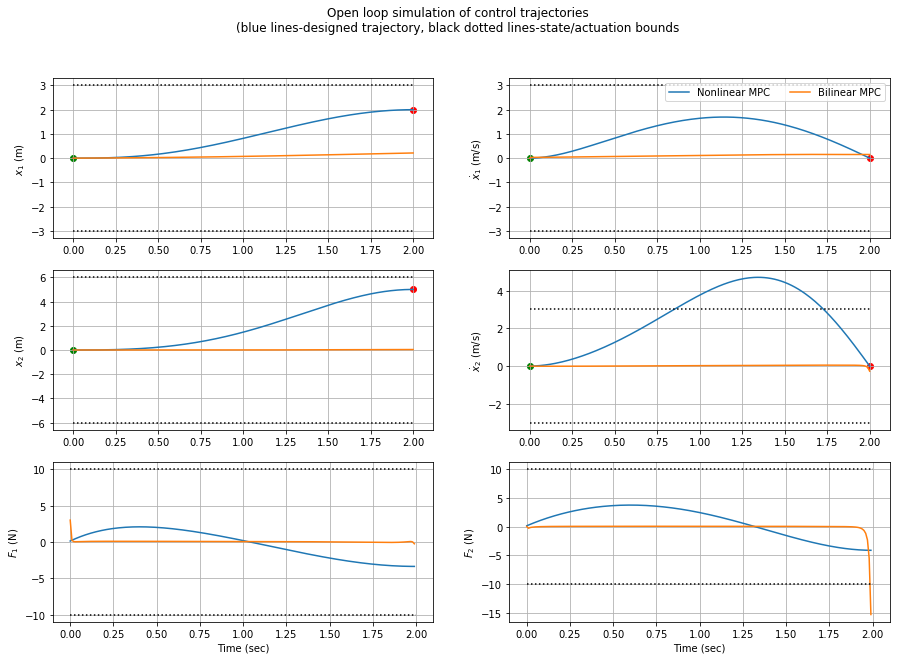

In [16]:
plt.figure(figsize=(15,10))
plt.suptitle('Open loop simulation of control trajectories\n(blue lines-designed trajectory, black dotted lines-state/actuation bounds')
for ii in range(6):
    ind = plot_inds[ii]
    if ii < 4:
        plt.subplot(3,2,ii+1)
        plt.plot(t_eval, xs_cl[ind,:], label='Nonlinear MPC')
        plt.plot(t_eval, xs_koop[ind,:], label='Bilinear MPC')
        plt.plot([0, 2.], [xmax[ind], xmax[ind]], ':k')
        plt.plot([0, 2.], [xmin[ind], xmin[ind]], ':k')
        plt.scatter(t_eval[0], x0[ind], color='g')
        plt.scatter(t_eval[-1], set_pt[ind], color='r')
        plt.ylabel(labels[ind])
        plt.grid()
        if ii==1:
            plt.legend(loc='upper right', ncol=2)
    else:
        plt.subplot(3,2,ii+1)
        plt.plot(t_eval[:-1],us_cl[ind,:])
        plt.plot(t_eval[:-1],us_koop[ind,:])
        plt.plot([0, 2.], [umax[ind], umax[ind]], ':k')
        plt.plot([0, 2.], [umin[ind], umin[ind]], ':k')
        plt.ylabel(labels[ii])
        plt.xlabel('Time (sec)')
        plt.grid()
            
plt.show()